In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import joblib
import torch
from Models.models import NNdynamic, plot_confusion_matrix, plot_metrics
from imblearn.over_sampling import SMOTE

In [2]:
data = pd.read_csv('Cleaned_full_data.csv')

C:\Users\adi_s\AppData\Local\Temp\ipykernel_3332\2584280520.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Cleaned_full_data.csv')


In [3]:
# Reset retained index.
data = data.reset_index(drop=True)
# Set NA to 0.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
data['attack_cat'] = data['attack_cat'].str.replace(r'\s+', '', regex=True)
data['attack_cat'] = data['attack_cat'].str.replace('Backdoors', 'Backdoor')

In [4]:
data = data.drop(columns=['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip'])

In [5]:
temp = data[['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat']]
data = data.drop(columns=['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat'])

In [6]:
# The resulting encoded features can be found in Tools/EncoderTests.
ohe1 = pd.read_csv('Full_proto_encoded.csv')
ohe2 = pd.read_csv('Full_dsport_encoded.csv')
ohe3 = pd.read_csv('Full_service_encoded.csv')
ohe4 = pd.read_csv('Full_state_encoded.csv')
# Spelling error.
ohe5 = pd.read_csv('Full_scrip_encoded.csv')
#------------------------------------------#
ohe6 = pd.read_csv('Full_sport_encoded.csv')
ohe7 = pd.read_csv('Full_dstip_encoded.csv')

In [7]:
# MinMax seperates Normal data well and reduces noise. Please see Kmeans TSNE evaluation in Tools.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
data = pd.DataFrame(scaled_data, columns=data.columns)
data = pd.concat([data, temp, ohe1, ohe2, ohe3, ohe4, ohe5, ohe6, ohe7], axis=1)

In [8]:
X_temp = data.drop(columns=['label'])
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y, test_size=0.2, random_state=42)
test_attack_cat = X_test['attack_cat']
print('Train:', y_train.value_counts())
print('Test', y_test.value_counts())
X_train = X_train.drop(columns=['attack_cat'])
X_test = X_test.drop(columns=['attack_cat'])

Train: label
0    1774933
1     257104
Name: count, dtype: int64
Test label
0    443831
1     64179
Name: count, dtype: int64


In [9]:
# Prepare batches.
batch_size = 128
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Epoch 1/1: 100%|██████████| 15876/15876 [01:27<00:00, 181.32batch/s]


Epoch [1/1], Train Loss: 0.0177, Train Acc: 0.9902, Train F1: 0.9900


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 346.36batch/s]


Test Loss: 0.0164, Test Accuracy: 0.9908, Test F1: 0.9906


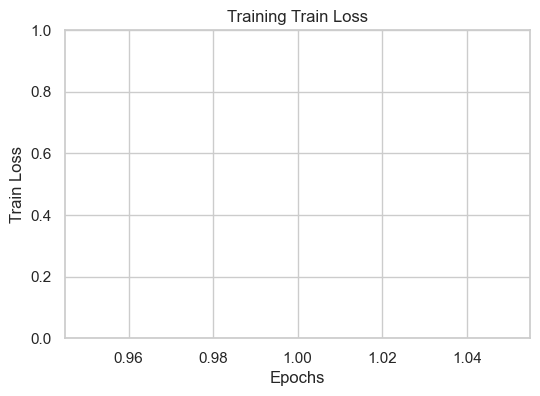

Standard Test


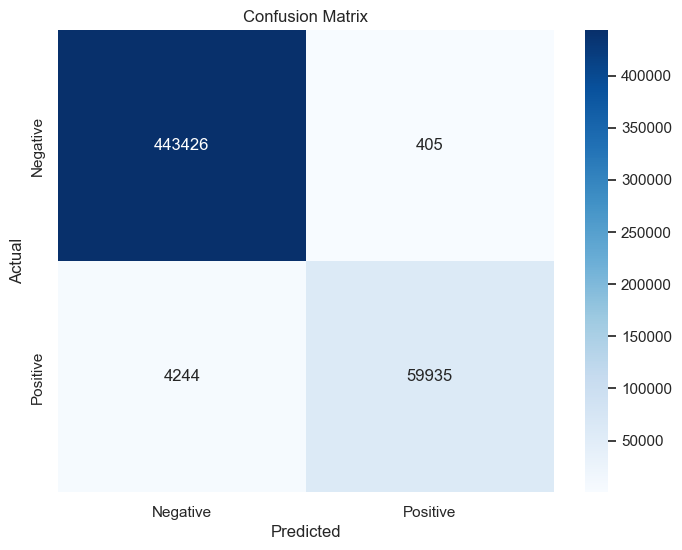

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/01/standard/'
model1 = NNdynamic(n_features, fc_size, device, save_dir)
# 37.23 min
sampler = None
params = None
learning_rate = 0.1
epochs = 1
save_factor = 1
model1.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
model1.test(test_loader)
plot_metrics(model1.train_loss, len(model1.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

In [11]:
X_train['preds'] = model1.train_predicted
X_train['actual'] = y_train
correct_threats = X_train[(X_train['preds'] == X_train['actual']) & (X_train['actual'] == 1)]
X_train2 = X_train.drop(correct_threats.index)

In [12]:
labels2 = X_train2['actual']
X_train2 = X_train2.drop(columns=['preds', 'actual'])

In [14]:
smote = SMOTE(random_state=42, sampling_strategy=0.25)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train2, labels2)

In [15]:
X_train_resampled = pd.DataFrame(X_train_resampled)
X_train_resampled['label'] = y_train_resampled

idx1 = X_train2.index
idx2 = X_train_resampled.index
synthetic_indices = list(set(idx2) - set(idx1))
X_s = X_train_resampled.loc[synthetic_indices].drop('label', axis=1)
y_s = X_train_resampled.loc[synthetic_indices, 'label']

C:\Users\adi_s\AppData\Local\Temp\ipykernel_3332\1316465726.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_resampled['label'] = y_train_resampled


In [16]:
X_s = torch.tensor(X_train2.values, dtype=torch.float32)
y_s = torch.tensor(labels2.values, dtype=torch.float32)

In [17]:
X_s = torch.cat((X_train_tensor, X_s), dim=0)
y_s = torch.cat((y_train_tensor, y_s), dim=0)

In [18]:
batch_size = 128
train_dataset = TensorDataset(X_s, y_s)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Epoch 1/5: 100%|██████████| 31511/31511 [02:16<00:00, 230.37batch/s]


Epoch [1/5], Train Loss: 0.0173, Train Acc: 0.9911, Train F1: 0.9908


Epoch 2/5: 100%|██████████| 31511/31511 [02:13<00:00, 235.20batch/s]


Epoch [2/5], Train Loss: 0.0168, Train Acc: 0.9909, Train F1: 0.9906


Epoch 3/5: 100%|██████████| 31511/31511 [02:17<00:00, 229.84batch/s]


Epoch [3/5], Train Loss: 0.0169, Train Acc: 0.9907, Train F1: 0.9904


Epoch 4/5: 100%|██████████| 31511/31511 [02:15<00:00, 232.65batch/s]


Epoch [4/5], Train Loss: 0.0163, Train Acc: 0.9911, Train F1: 0.9908


Epoch 5/5: 100%|██████████| 31511/31511 [02:20<00:00, 223.98batch/s]


Epoch [5/5], Train Loss: 0.0166, Train Acc: 0.9908, Train F1: 0.9905


Testing: 100%|██████████| 3969/3969 [00:12<00:00, 318.72batch/s]

Test Loss: 0.0172, Test Accuracy: 0.9913, Test F1: 0.9911


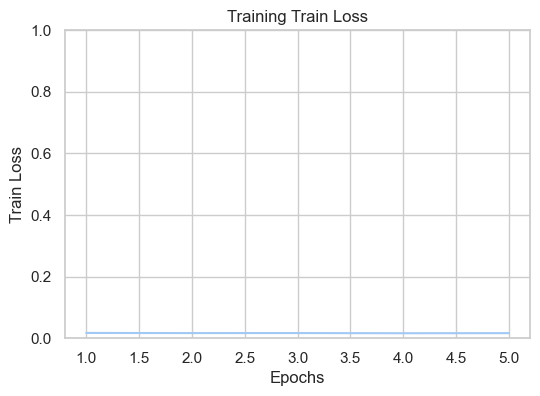

Standard Test


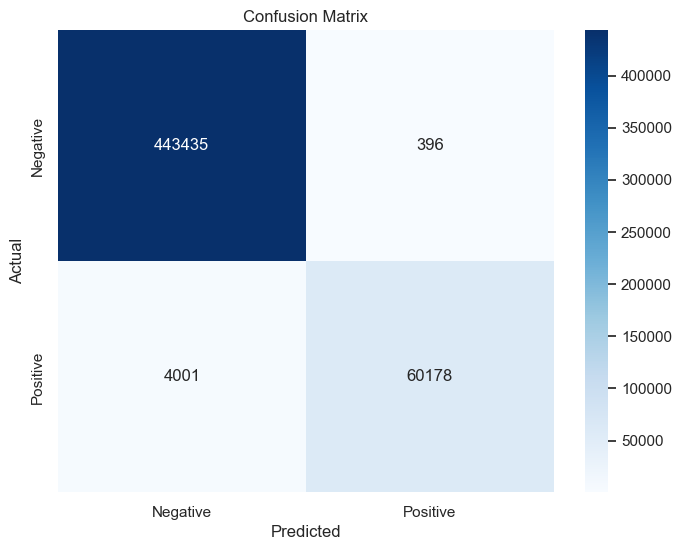

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/02/smote1'
model1 = NNdynamic(n_features, fc_size, device, save_dir)
# 37.23 min
sampler = None
params = None
learning_rate = 0.1
epochs = 5
save_factor = 1
# Not sure why it started running so slow.. maybe because saving the sampled data.
model1.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
model1.test(test_loader)
plot_metrics(model1.train_loss, len(model1.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

c:\Users\adi_s\Desktop\LSTM\Models\models.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 1


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 337.61batch/s]


Test Loss: 0.0160, Test Accuracy: 0.9914, Test F1: 0.9912


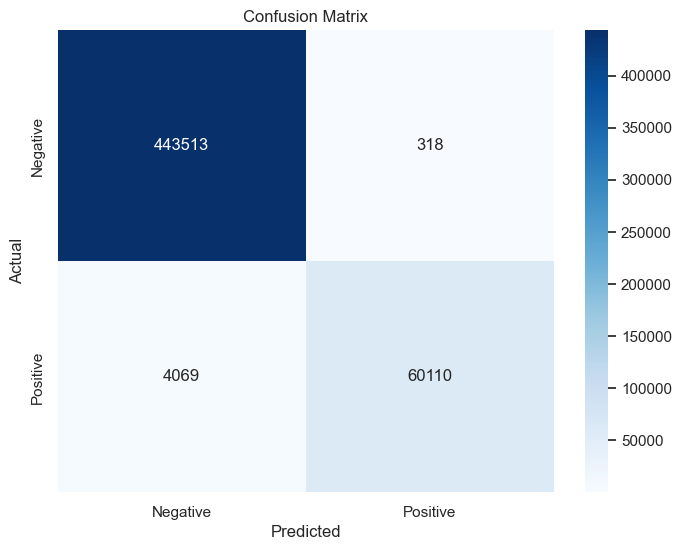

c:\Users\adi_s\Desktop\LSTM\Models\models.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 2


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 339.32batch/s]


Test Loss: 0.0201, Test Accuracy: 0.9909, Test F1: 0.9907


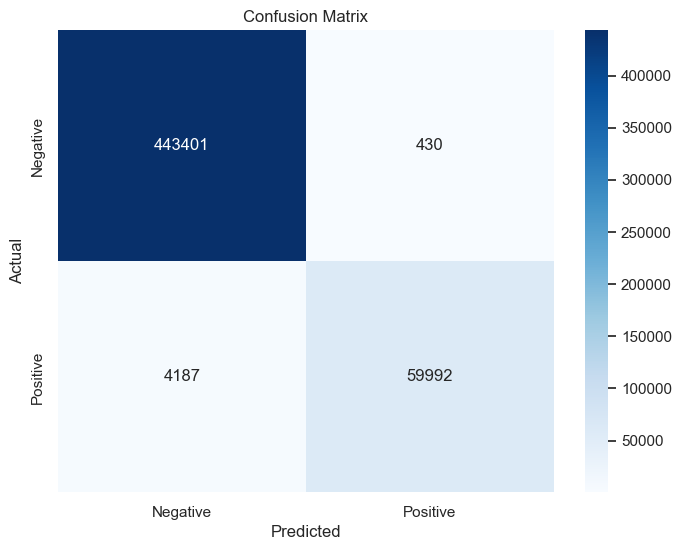

c:\Users\adi_s\Desktop\LSTM\Models\models.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 3


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 350.79batch/s]


Test Loss: 0.0160, Test Accuracy: 0.9907, Test F1: 0.9905


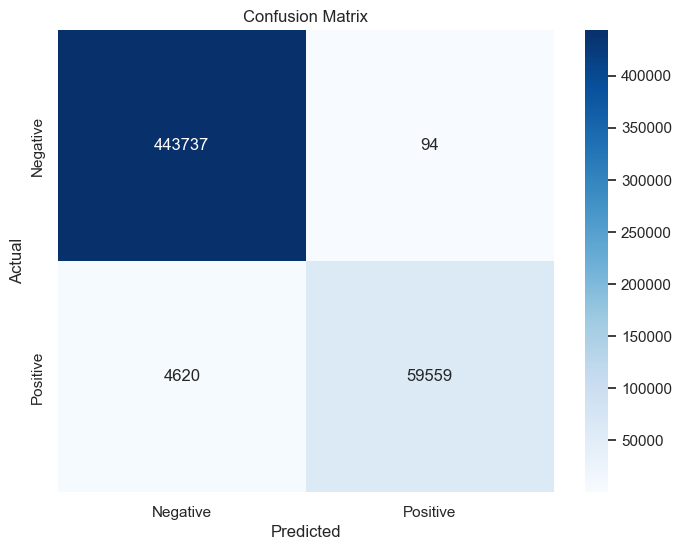

c:\Users\adi_s\Desktop\LSTM\Models\models.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 4


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 342.60batch/s]


Test Loss: 0.0179, Test Accuracy: 0.9893, Test F1: 0.9889


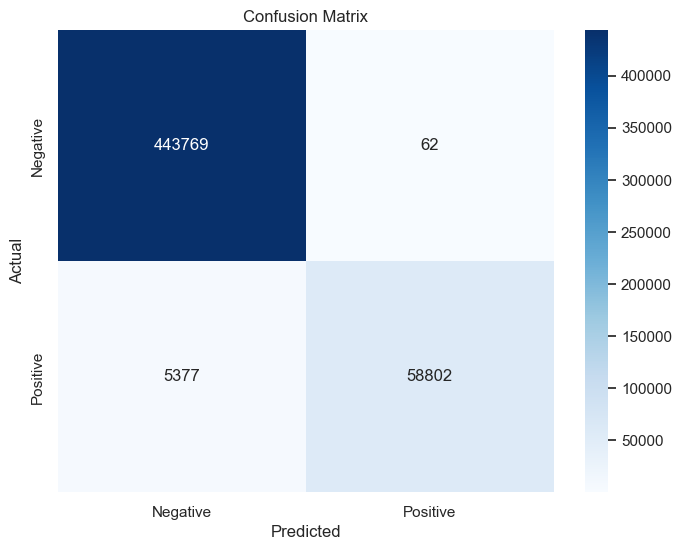

c:\Users\adi_s\Desktop\LSTM\Models\models.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 5


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 350.06batch/s]


Test Loss: 0.0172, Test Accuracy: 0.9913, Test F1: 0.9911


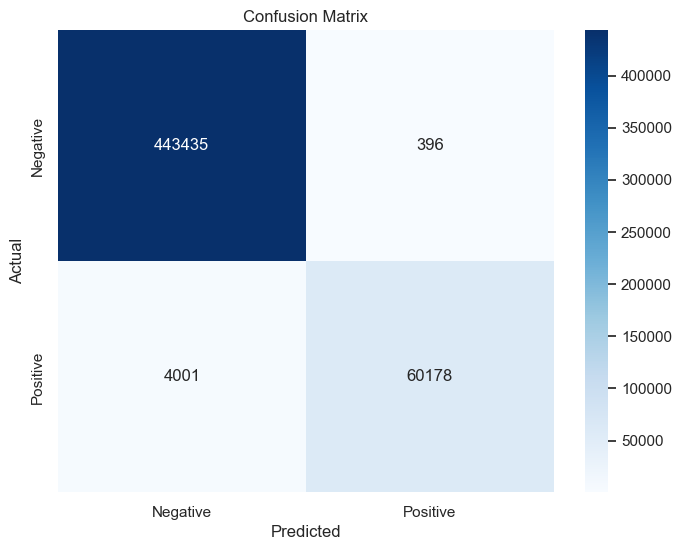

In [20]:
for i in range(1, epochs+1):
    path = f"./Models/saved_models/02/smote1/PB_epoch_{i}.pth"
    model1.load_model(path)
    print(f"Epoch: {i}")
    model1.test(test_loader)
    y_pred = np.array(model1.test_predicted)
    y_true = []
    for _, labels in test_loader:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)
    plot_confusion_matrix(y_true, y_pred)
    model1.test_predicted = []

Implementation through batches is extremely complex but I might give it a go later.